cattbl
===========

Python modules for working in pandas with various loss data tables used for CAT modelling


## Example YELT
In this case there is a separate index level for the Model ID, which categorises groups of events. There are also two loss perspectives stored in separate columns of a dataframe. 

In [1]:
import pandas as pd
from cattbl import yeareventloss

yelts = pd.read_csv("tests/_data/example_two_models_grossnet.csv")
yelts = yelts.set_index(['Year', 'ModelID', 'EventID', 'DayOfYear'])
yelts.attrs['n_yrs'] = 1e5
display(yelts)

,,,,GrossLoss,NetLoss
Year,ModelID,EventID,DayOfYear,,
4,Model1,32132,34,1369.474539,0.0
5,Model1,12433,154,5345.585367,0.0
6,Model1,41862,207,1642.805623,0.0
10,Model1,47338,129,1129.154573,0.0
11,Model1,178,265,1162.232135,0.0
...,...,...,...,...,...
99998,Model2,18105,249,1522.623354,0.0
99999,Model2,52117,349,1697.083791,0.0
100000,Model2,53907,185,1199.493510,0.0


### Partitioning of the YLT
We can create a Year Loss Table, but retain the split between model ID in separate columns.

In [2]:
ylt_bymodel = (yelts['GrossLoss'].yel
               .to_ylt_partitioned(splitby='ModelID')
               )
display(ylt_bymodel.head())
# ylt_bymodel.attrs


ModelID,Model1,Model2
Year,,
1,0.000000,1499.872346
3,0.000000,2762.839798
4,1369.474539,0.000000
5,5345.585367,1857.134201
6,1642.805623,0.000000


We can combine the partitioned YLT with the total YLT and its EP curve

In [3]:
partitioned_aepcurve = (ylt_bymodel
 .join(yelts['GrossLoss'].yel.to_ylt())
 .join(yelts['GrossLoss'].yel.to_ylt().yl.exprob())
 .sort_values('ExProb', ascending=True)
)
display(partitioned_aepcurve)

,Model1,Model2,GrossLoss,ExProb
Year,,,,
49498,5.916843e+07,1482.675687,5.916991e+07,0.00001
93402,3.256876e+07,1766.049865,3.257052e+07,0.00002
45842,1.314828e+07,1026.059510,1.314930e+07,0.00003
28986,6.493891e+06,3026.337002,6.496918e+06,0.00004
27363,6.412241e+06,0.000000,6.412241e+06,0.00005
...,...,...,...,...
82567,1.000041e+03,0.000000,1.000041e+03,0.77769
54501,1.000017e+03,0.000000,1.000017e+03,0.77770
46477,1.000007e+03,0.000000,1.000007e+03,0.77771


Visualise the split as a stacked survivor function

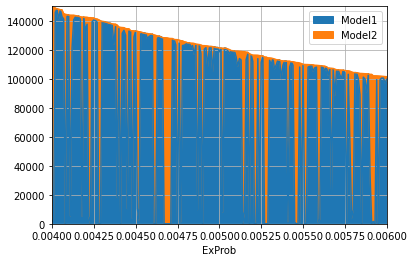

In [4]:
from matplotlib import pyplot as plt

fig, ax = plt.subplots(1)
(partitioned_aepcurve
 .sort_values('ExProb', ascending=True)
 .plot.area(x='ExProb', y=['Model1', 'Model2'], ax=ax)
)
ax.set(xlim=(0.004, 0.006), ylim=(0, 150e3))
ax.grid(True)
plt.show()

We can also look at the average contribution of each model at each exceedance probability

In [5]:
tvar_bymodel = partitioned_aepcurve.copy().sort_values('ExProb', ascending=True)
tvar_bymodel['TVaR'] = tvar_bymodel['GrossLoss']

for c in ['Model1', 'Model2', 'TVaR']:
    tvar_bymodel[c] = tvar_bymodel[c].cumsum() / (ylt_bymodel.attrs['n_yrs'] * tvar_bymodel['ExProb'])
tvar_bymodel



,Model1,Model2,GrossLoss,ExProb,TVaR
Year,,,,,
49498,5.916843e+07,1482.675687,5.916991e+07,0.00001,5.916991e+07
93402,4.586859e+07,1624.362776,3.257052e+07,0.00002,4.587022e+07
45842,3.496182e+07,1424.928354,1.314930e+07,0.00003,3.496325e+07
28986,2.784484e+07,1825.280516,6.496918e+06,0.00004,2.784666e+07
27363,2.355832e+07,1460.224413,6.412241e+06,0.00005,2.355978e+07
...,...,...,...,...,...
82567,7.200450e+03,3886.104945,1.000041e+03,0.77769,1.108655e+04
54501,7.200370e+03,3886.054976,1.000017e+03,0.77770,1.108642e+04
46477,7.200290e+03,3886.005008,1.000007e+03,0.77771,1.108630e+04


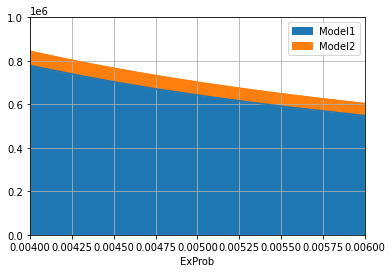

In [6]:

fig, ax = plt.subplots(1)
(tvar_bymodel
 .plot.area(x='ExProb', y=['Model1', 'Model2'], ax=ax)
)
ax.set(xlim=(0.004, 0.006), ylim=(0, 1e6))
# ax.set(xscale='log')
ax.grid(True)
plt.show()